# Non-linear models: Binary Response

This week's problem set deals with settings where the outcome can take only two values, $y_i \in \{0,1\}$. 

## Theory

The binary response model assumes that the data generating process is 
$$
\begin{aligned}
y_i^* &= \mathbf{x}_i \boldsymbol{\beta} + u_i, \\ 
y_i   &= \mathbf{1}(y_i^* > 0), 
\end{aligned}
$$
where $u_i$ are distributed IID according to some cdf. $G$. 

In the lectures, we show that 
$$ p_i \equiv \Pr(y_i = 1| \mathbf{x}_i) = G(\mathbf{x}_i \boldsymbol{\beta}). $$ 

Since $y_i$ (conditioning on $\mathbf{x}_i$) is Bernoulli-distributed with parameter $p_i$, its log-likelihood function is 
$$
\ell_i(\theta) 
               = \mathrm{1}(y_i = 1) \log[ G(\mathbf{x}_i \boldsymbol{\beta}) ]
               + \mathrm{1}(y_i = 0) \log[1 - G(\mathbf{x}_i \boldsymbol{\beta})]
$$

Estimation is then conducted by maximum likelihood, 
$$ \hat{\boldsymbol{\theta}} = \arg\max_\theta \frac{1}{N} \sum_{i=1}^N \ell_i (\theta), $$ 
which can be implemented as a minimizer in the usual $M$-framework with $q(\theta, y_i, x_i) = -\ell_i(\theta)$, and then minimizing $Q(\theta) = N^{-1} \sum_i q(\theta, y_i, x_i)$. 

We will consider two models in this problem set: 
1. Probit: when $G$ is the standard normal CDF (question 2) 
2. Logit: when $G$ is the standard logistic CDF (question 4). 

And we will be comparing them to OLS (which we call the Linear Probability Model, LPM, when $y_i$ is binary). 

## Setup 

In [188]:
# We will import the LinearModels module
# But first we need to make sure that we look for modules one folder up.
from sys import path

import numpy as np
import pandas as pd 
from scipy.stats import norm
import matplotlib.pyplot as plt 
import seaborn as sns 
sns.set_theme()

%load_ext autoreload
%autoreload 2

# user-written 
import estimation as est 
import LinearModel as lm
import probit_ante as probit
import logit_ante as logit

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Labor participation of married women

The goal of this week's problem set is to investigate the labor participation of 
married women, using three different types of binary response models.
Binary response models are relevant when the dependent variable $y$ has two possible outcomes, 
e.g., $y=1$ if a person participates in the labor force, and $y=0$ if she does not.
The three models that you are asked to estimate are the Linear Probability Model (LPM), 
the Probit model and the Logit model. 

_Note:_ This week, most of the code has been created for you - you just need to fill in some blanks in the module `NonLinearModel.py`. To estimate the LPM-model using OLS, we will use the code that we have already used in the course, which is in the `LinearModels.py` file, and is preloaded as `lm`.

## Data

To conduct your analysis, you will use data coming from the following article, and reproduce
some of its results: 

> Michael Gerfin (1996): "Parametric and Semi-Parametric Estimation of the Binary Response Model of Labour Market Participation", _Journal of Applied Econometrics_ , Vol. 11, Issue 3, pp. 321-339, [DOI link](https://doi.org/10.1002/(SICI)1099-1255(199605)11:3%3C321::AID-JAE391%3E3.0.CO;2-K)

This article compares parametric and semiparametric methods for the estimation of binary choice
models, using two different data sets for Swiss and German women. In this assignment, you will
only work with the Swiss data, and implement parametric methods - we will discuss semiparametric 
methods in a later lecture. 

The data set $\texttt{swiss.txt}$ contains information about 872 women, of which 401
participate in the labor market (The data set was obtained from the Journal of Applied Econometrics Data Archive
at http://qed.econ.queensu.ca/jae/1996-v11.3/gerfin/.


The variables are defined in the table below (see, also, section 3 page 326 of the article).

|Var | Definition |
|--|--|
| `LFP`     |  = 1 if in labor force, 0 otherwise | 
| `AGE`     |  age in years (divided by 10) | 
| `EDUC`    |  number of years of formal education | 
| `NYC`     |  number of young children | 
| `NOC`     |  number of older children | 
| `NLINC`   |  logarithm of yearly non-labor income | 
| `FOREIGN` |  = 1 if permanent foreign resident, 0 otherwise |



### The following cells load the data for you.

In [189]:
# Declare labels
y_lab = 'lfp'
rawdat_columns = ['lfp', 'nlinc', 'age', 'educ', 'nyc', 'noc', 'foreign'] # contents of raw file 
x_lab = ['const', 'age', 'agesq', 'educ', 'nyc', 'noc', 'nlinc', 'foreign'] # goal for our dataset 

In [190]:
dat = pd.read_fwf('swiss.txt', names = rawdat_columns)

N = dat.shape[0]

# create extra variables 
dat['agesq'] = dat.age * dat.age 
dat['const'] = np.ones((N,))

# reorder columns 
dat = dat[[y_lab] + x_lab].copy()



assert dat.notnull().all(axis=1).all(), 'Missings in the dataset, take them out!'

dat.head(5)

,lfp,const,age,agesq,educ,nyc,noc,nlinc,foreign
0,0.0,1.0,3.0,9.00,8.0,1.0,1.0,10.787497,0.0
1,1.0,1.0,4.5,20.25,8.0,0.0,1.0,10.524251,0.0
2,0.0,1.0,4.6,21.16,9.0,0.0,0.0,10.968578,0.0
3,0.0,1.0,3.1,9.61,11.0,2.0,0.0,11.104999,0.0
4,0.0,1.0,4.4,19.36,12.0,0.0,2.0,11.108470,0.0


In [191]:
y = dat.lfp.values
x = dat[x_lab].values
K = x.shape[1]

# Question 1: Estimate model using LPM
We model Labour participation of females using an LPM model, which we estimate using OLS. Use the given `lm` module, and print it out in a nice table. Remember to use heteroscedasticity-robust standard errors. 

In [192]:
ols_results =  lm.estimate(y=y, x=x, robust_se=True) # Fill in
ols_tab = lm.print_table((y_lab, x_lab), ols_results, title='LPM results')
ols_tab

LPM results
Dependent variable: lfp

R2 = 0.193
sigma2 = nan


,b_hat,se,t
const,1.6637,0.3973,4.1880
age,0.6825,0.1200,5.6891
agesq,-0.0970,0.0145,-6.6821
educ,0.0067,0.0058,1.1502
nyc,-0.2406,0.0301,-8.0031
noc,-0.0493,0.0174,-2.8291
nlinc,-0.2128,0.0355,-5.9892
foreign,0.2496,0.0402,6.2134


In [193]:
2.5*ols_results['b_hat']

array([ 4.15920822,  1.70634457, -0.24256487,  0.01664176, -0.60157582,
       -0.12327269, -0.53210452,  0.62400311])

You should get something close to this: 

|         |   b_hat |     se |   t        |
|:--------|--------:|-------:|-----------:|
| const   |  1.6637 | 0.3973 |     4.188  |
| age     |  0.6825 | 0.12   |     5.6891 |
| agesq   | -0.097  | 0.0145 |    -6.6821 |
| educ    |  0.0067 | 0.0058 |     1.1502 |
| nyc     | -0.2406 | 0.0301 |    -8.0031 |
| noc     | -0.0493 | 0.0174 |    -2.8291 |
| nlinc   | -0.2128 | 0.0355 |    -5.9892 |
| foreign |  0.2496 | 0.0402 |     6.2134 |


# Question 2: Probit

The Probit model has the link function 
$$G^{\text{probit}}(\mathbf{x}_i \boldsymbol{\beta}) 
    =\Phi(\mathbf{x}_i \boldsymbol{\beta})
    \equiv \int_{-\infty}^{\mathbf{x}_i \boldsymbol{\beta}}\phi\left(z\right) \, \mathrm{d} z$$

$\phi\left(z\right)= (2 \pi)^{-\frac12}\exp(\frac{-z^{2}}{2})$ is the standard normal pdf. As starting values, we can use OLS estimates: $\boldsymbol{\theta} = \hat{\boldsymbol{\beta}}^{OLS}$. *(Or even better, $2.5\hat{\boldsymbol{\beta}}^{OLS}$, as will become clear later.) 

> Estimate the probit model. You'll need to fill in the `probit_ante.py` file. Specifically, fill out the functions `G`, `loglikelihood`, `q`, and `starting_values` so that the code below runs and gives the correct answers. 

***Hints:*** 
* $\Phi(z)$ can be computed with `scipy.stats.norm.cdf(z)`.
* Make sure to keep `theta` "flat", i.e. `theta.ndim == 1`. 

In [194]:
#Use the 2.5 times ols estimate as a starting value
theta0 = probit.starting_values(y, x)
print(theta0)

[ 4.15920822  1.70634457 -0.24256487  0.01664176 -0.60157582 -0.12327269
 -0.53210452  0.62400311]


In [195]:
ll = probit.loglikelihood(theta0, y, x)
np.isclose(np.mean(ll), -1.0411283428047824)

True

In [196]:
probit_results = est.estimate(probit.q, theta0, y, x)

Optimization terminated successfully.
         Current function value: 0.583231
         Iterations: 36
         Function evaluations: 369
         Gradient evaluations: 41


In [197]:
probit_tab = est.print_table(x_lab, probit_results, title=f'Probit, y = {y_lab}')
probit_tab

Optimizer succeded after 36 iter. (369 func. evals.). Final criterion:   0.5832.
Probit, y = lfp


,theta,se,t
const,3.7489,1.4948,2.5080
age,2.0754,0.4169,4.9784
agesq,-0.2944,0.0509,-5.7836
educ,0.0192,0.0181,1.0619
nyc,-0.7145,0.0963,-7.4170
noc,-0.1470,0.0503,-2.9222
nlinc,-0.6669,0.1372,-4.8607
foreign,0.7144,0.1207,5.9196


Your table should look aprox. this:

Optimizer succeded after 36 iter. (360 func. evals.). Final criterion:   0.5832.
Probit, y = lfp

|         |   theta |     se |       t |
|:--------|--------:|-------:|--------:|
| const   |  3.7489 | 1.4948 |  2.5080 |
| age     |  2.0754 | 0.4169 |  4.9784 |
| agesq   | -0.2944 | 0.0509 | -5.7836 |
| educ    |  0.0192 | 0.0181 |  1.0619 |
| nyc     | -0.7145 | 0.0963 | -7.4170 |
| noc     | -0.1470 | 0.0503 | -2.9222 |
| nlinc   | -0.6669 | 0.1372 | -4.8607 |
| foreign |  0.7144 | 0.1207 |  5.9196 |

In [198]:
# mean value of G(x*theta): 0.46066
probit.G(x @ probit_results['theta']).mean()

0.4606643716526391

> What is the interpretation of $\bar{G(\mathbf{x}\boldsymbol{\beta})}$?

This is the partial effect at the average (PEA), that is the characteristics `x` of 'the average individual' on `y` (being employed `y=1`)

![PEA v APE](partial_effect_at_the_average_vs_average_partial_effect.png)

# Question 3: Compare estimates to Gerfin (1996)
Compare your results to those published in Gerfin (1996, p. 327 Table I) for the Probit model, see the table below. Do you get similar results? Interpret and compare the results from the two estimation approaches (LPM and Probit). What can (and can’t) you compare across the two models simply from looking at the estimated parameters?

| Variable | $\hat{\beta}$ | s.e |
|----|---|---|
| `CONST`   |  3.75	| (1.41)  |
| `AGE`     |  2.08	| (0.41)  |
| `AGESQ`   |  -0.29| (0.05) | 
| `EDUC`    |  0.02	| (0.02)  |
| `NYC`     |  -0.71| (0.10) | 
| `NOC`     |  -0.15| (0.05) | 
| `NLINC`   |  -0.67| (0.13) | 
| `FOREIGN` |   0.71|  (0.12)|

# Question 4: Logit
Estimate the logit model with maximum likelihood, using the same explanatory variables as in
**Question 3**. As starting values, we can use OLS estimates: $\boldsymbol{\theta} = \hat{\boldsymbol{\beta}}^{OLS}$. *(Or even better, $4\hat{\boldsymbol{\beta}}^{OLS}$, as will become clear later.) 

## The Logit Model

For the Logit model, the link function is 

$$G^{\text{logit}}( \mathbf{x}_i \boldsymbol{\beta} ) = \Lambda(\mathbf{x}_i \boldsymbol{\beta}) \equiv  \frac{\exp(\mathbf{x}_i \boldsymbol{\beta})}{1+\exp(\mathbf{x}_i \boldsymbol{\beta})} = \frac{1}{1+\exp(-\mathbf{x}_i \boldsymbol{\beta})} \tag{2}$$

> Estimate the logit model. You'll need to fill in the `logit_ante.py` file. Specifically, fill out the functions `G`, `loglikelihood`, `q`, and `starting_values` so that the code below runs and gives the correct answers. 

In [199]:
#Use the 4 times ols estimate as a starting value
theta0 = logit.starting_values(y, x)
theta0 

array([ 6.65473316,  2.73015131, -0.38810379,  0.02662682, -0.96252132,
       -0.1972363 , -0.85136724,  0.99840498])

In [200]:
ll = logit.loglikelihood(theta0, y, x)
np.isclose(np.mean(ll),-0.9974267061091704)

True

In [201]:
logit_results = est.estimate(logit.q, theta0, y, x)

Optimization terminated successfully.
         Current function value: 0.583469
         Iterations: 47
         Function evaluations: 441
         Gradient evaluations: 49


In [202]:
logit_tab = est.print_table(x_lab, logit_results, title=f'Logit, y = {y_lab}')
logit_tab

Optimizer succeded after 47 iter. (441 func. evals.). Final criterion:   0.5835.
Logit, y = lfp


,theta,se,t
const,6.1955,2.4821,2.4960
age,3.4368,0.7091,4.8464
agesq,-0.4877,0.0872,-5.5928
educ,0.0327,0.0302,1.0819
nyc,-1.1857,0.1647,-7.2010
noc,-0.2410,0.0833,-2.8940
nlinc,-1.1040,0.2304,-4.7914
foreign,1.1683,0.2025,5.7689


Expected output: 

Optimizer succeded after 47 iter. (441 func. evals.). Final criterion:   0.5835.
Logit, y = lfp

|         |   theta |     se |       t |
|:--------|--------:|-------:|--------:|
| const   |  6.1955 | 2.4821 |  2.496  |
| age     |  3.4368 | 0.7091 |  4.8464 |
| agesq   | -0.4877 | 0.0872 | -5.5928 |
| educ    |  0.0327 | 0.0302 |  1.0819 |
| nyc     | -1.1857 | 0.1647 | -7.201  |
| noc     | -0.241  | 0.0833 | -2.894  |
| nlinc   | -1.104  | 0.2304 | -4.7914 |
| foreign |  1.1683 | 0.2025 |  5.7689 |

# Question 5: Comparing the raw parameter estimates 

A frequent rule of thumb is that the relationship between the parameter estimates is 
$$
\begin{aligned}
\hat{\boldsymbol{\beta}}_{Logit}&\simeq4\hat{\boldsymbol{\beta}}_{OLS}\\
\hat{\boldsymbol{\beta}}_{Probit}&\simeq2.5\hat{\boldsymbol{\beta}}_{OLS}\\
\hat{\boldsymbol{\beta}}_{Logit}&\simeq1.6\hat{\boldsymbol{\beta}}_{Probit}
\end{aligned}
$$

Test this by calculating the ratios between the estimated coefficients: 
$$\left(\frac{\hat{\boldsymbol{\beta}}_{Logit}}{\hat{\boldsymbol{\beta}}_{OLS}}, \frac{\hat{\boldsymbol{\beta}}_{Probit}}{\hat{\boldsymbol{\beta}}_{OLS}},\frac{\hat{\boldsymbol{\beta}}_{Logit}}{\hat{\boldsymbol{\beta}}_{Probit}} \right)$$

***Hint:*** Parameters are either in the results dictionaries, e.g. `probit_results['theta']`, or in the pandas dataframes, `probit_tab.theta`. 

In [203]:
print('Probit / OLS')
pd.Series(probit_results['theta']/ols_results['b_hat'],index=x_lab)

Probit / OLS


const      2.253372
age        3.040689
agesq      3.033776
educ       2.883545
nyc        2.969238
noc        2.980965
nlinc      3.133486
foreign    2.862019
dtype: float64

In [204]:
print('Logit / OLS')
pd.Series(logit_results['theta']/ols_results['b_hat'], index=x_lab)

Logit / OLS


const      3.723962
age        5.035379
agesq      5.026180
educ       4.906557
nyc        4.927644
noc        4.886577
nlinc      5.187174
foreign    4.680807
dtype: float64

In [205]:
print('Logit / Probit')
pd.Series(logit_results['theta']/probit_results['theta'], index=x_lab)

Logit / Probit


const      1.652618
age        1.655999
agesq      1.656741
educ       1.701571
nyc        1.659565
noc        1.639260
nlinc      1.655400
foreign    1.635491
dtype: float64

# Question 6: Marginal effects for a continuous variable
Calculate the marginal effect of taking one additional year of
education (coefficient `k = 3`) on the probability of participating in the labor market 
for a woman with the following characteristics, `x_me`: 

|      |   const |   age |   agesq |   educ |   nyc |   noc |   nlinc |   foreign |
|:-----|--------:|------:|--------:|-------:|------:|------:|--------:|----------:|
| x_me |       1 |   2.5 |    6.25 |     10 |     1 |     0 |      10 |         0 |

* *Note:* `age` is divided by 10, so 2.5 does make sense. 

Consider education as a continuous variable. The marginal effect should be calculated for the LPM, the probit and the logit models.

The partial (also called marginal) effects in the Logit and Probit
models depend upon the regressors, $x_{k}$. For continuous variables the
partial effects are given as,
$$
\begin{aligned} 
\text{Marginal effect} : \frac{\partial P\left(y_{i}=1\left|\mathbf{x}_i \right.\right)}{\partial x_{ik}}
&=G'(\mathbf{x}_i \boldsymbol{\beta}) 
   \frac{\partial \mathbf{x}_i \boldsymbol{\beta}}{\partial x_{ik}}  \\
&=g(\mathbf{x}_i \boldsymbol{\beta})\beta_{k}
\end{aligned} 
$$
where the derivatives of the CDF, $G'(z) \equiv g(z)$, for the logit and probit models are given by
$$
\begin{aligned} 
g^{\text{logit}}\left(z\right) &= \frac{\exp\left(z\right)}{\left[ 1+\exp\left(z\right)\right] ^2} \\ 
g^{\text{probit}}\left(z\right) &= \phi(z) \equiv \frac{1}{\sqrt{2\pi}}\exp\left(\frac{-z^{2}}{2}\right)
\end{aligned} 
$$


In [206]:
# Let us make a vector of the values we want to investigate
x_me = np.array([1.0, 2.5, 2.5**2, 10, 1, 0, 10, 0]).reshape(1, -1)
pd.DataFrame(x_me, columns=x_lab, index=['x_me'])

,const,age,agesq,educ,nyc,noc,nlinc,foreign
x_me,1.0,2.5,6.25,10.0,1.0,0.0,10.0,0.0


In [207]:
k = 3 # the parameter to take derivative wrt. 

# Let us get the beta coefficients that we are interested in.
b_pr = probit_tab.theta.values
b_lg = logit_tab.theta.values

# Calculate the marginal effects both for the logit and probit.
# For the probit, you can use norm.pdf for g
# For the logit, g is straightforward algebra 
me_educ_pr = norm.pdf(x_me@b_pr)*b_pr # Fill in 
me_educ_lg = (np.exp(x_me@b_lg)/(1+np.exp(x_me@b_lg))**2)*b_lg # Fill in 

# print results 
pd.DataFrame([ols_results['b_hat'][k], 
              me_educ_pr[k],
              me_educ_lg[k]],
             index=['OLS', 'Probit', 'Logit'], columns=[f'Marg. Eff. of {x_lab[k]}']).round(6)

,Marg. Eff. of educ
OLS,0.006657
Probit,0.007626
Logit,0.008123


Expected output: 

|        |   Marg. Eff. of educ |
|:-------|---------------------:|
| OLS    |             	0.006657|
| Probit |           	0.007626|
| Logit  |              0.008123|

# Question 7: Marginal effect for dummy variables 

Calculate the marginal effect of being a permanent foreign resident on the probability of participating in the labor market.


For discrete variables the partial effects are given as,
$$
G\left(\beta_{0}+\beta_{1}x_{1}+\cdots+\beta_{K-1}x_{K-1}+\color{red}{\beta_{K}} \right)-G\left(\beta_{0}+\beta_{1}x_{1}+\cdots+\beta_{K-1}x_{K-1}\right)
$$

where $G$ is either $\Phi$ for the probit model, and $\Lambda$ for the logit.


In [208]:
# We will look at the same values as previously, but we want to look at the difference for foreign = 0 and foreign = 1.
k = 7 
x_me2 = x_me.copy()
x_me2[:, k] = 1  # Keep everythin the same, but change foreign to 1 for all obs. 

# evaluate G at the two different "x beta"s
me_foreign_pr = probit.G(x[:, :k]@b_pr[:k]+b_pr[k])-probit.G(x[:, :k]@b_pr[:k]) # FILL IN 
me_foreign_lg = logit.G(x[:, :k]@b_lg[:k]+b_lg[k])-logit.G(x[:, :k]@b_lg[:k]) # FILL IN 

# print results 
pd.DataFrame([ols_results['b_hat'][k], 
              me_foreign_pr[0], # assuming me_foreign_pr is an array, otherwise remove "[0]"
              me_foreign_lg[0]],
             index=['OLS', 'Probit', 'Logit'], columns=[f'Marg. Eff.: {x_lab[k]}']).round(4)

,Marg. Eff.: foreign
OLS,0.2496
Probit,0.2727
Logit,0.2751


Expected output: 

|        |   Marg. Eff. of educ |
|:-------|---------------------:|
| OLS    |             	0.2496|
| Probit |           	0.2700|
| Logit  |              0.2726|

# Question 8: Standard errors of the marginal effects with the Delta Method

(This part refers to the material covered in the note, "The Delta Method".) 

Marginal effects are a function of the estimated parameters, $\mathbf{h}(\hat{\theta})$, which is a $K$-vector. The Delta Method tells us how to compute standard errors for $\mathbf{h}(\hat{\boldsymbol{\theta}})$ based on an estimated covariance matrix for $\hat{\boldsymbol{\theta}}$. To do this, define the $K \times K$ matrix of derivatives of $\mathbf{h}$
$$ \mathbf{g} = \nabla_\theta \mathbf{h}(\hat{\boldsymbol{\theta}}).$$

Then we have 
$$ \text{Avar}[\mathbf{h}(\hat{\boldsymbol{\theta}})] = \mathbf{g} \, \text{Avar}(\hat{\boldsymbol{\theta}}) \, \mathbf{g}'$$

## Probit

In the following, you should compute the standard errors for the two marginal effects computed earlier, continuous (education) and discrete (foreign). 

### Continuous case 
From the note, we have 

$$ \mathbf{g} = \phi(\mathbf{x}_0 \hat{\boldsymbol{\beta}}) 
    \left [\mathbf{I}_{K\times K} - (\hat{\boldsymbol{\beta}} \hat{\boldsymbol{\beta}}') (\mathbf{x}_0' \mathbf{x}_0) \right] $$ 

Note that both $\hat{\boldsymbol{\beta}} \hat{\boldsymbol{\beta}}'$ and $\mathbf{x}_0' \mathbf{x}_0$ are $K \times K$ matrices (outer products). 

***Hints:*** 
* When a vector has `ndim == 1`, transposing does nothing, so use `np.outer(a, a)` to get the outer product matrix.  
* `np.eye(K)` gives the $K\times K$ identity matrix, $\mathbf{I}_{K \times K}$. 

### Discrete case 

Here, we simply evaluate 
$$ \mathbf{g}_k = \phi(\mathbf{x}_1 \hat{\boldsymbol{\beta}}) \mathbf{x}_1 - \phi(\mathbf{x}_0 \hat{\boldsymbol{\beta}}) \mathbf{x}_0, $$
which is just $1 \times K$ (as $\mathbf{h}$), where the effect is coming only through the changes from $\mathbf{x}_0$ to $\mathbf{x}_1$ (which are subsumed in the notation, but we changed only the `k`th element of `x_me`.)

***Hint:*** Check the output dimensions

In [209]:
# FILL IN 
bb  = np.outer(probit_results['theta'], probit_results['theta']) # outer product of probit parameters
xx  = np.outer(x_me, x_me) # outer product of x_me
I_k = np.eye(K) # identity matrix 
gx0 = norm.pdf(x_me) # g evaluated at x_me 
gx2 = norm.pdf(x_me2) # g evaluated at x_me2

# the formula (done for you)
grad_c_pr = gx0*(I_k - bb @ xx)
grad_d_pr = gx2*x_me2 - gx0*x_me

Verify that you get the right dimensions 

In [210]:
grad_c_pr.shape == (8,8)

True

In [211]:
grad_d_pr.shape == (1,8)

True

$$ \text{Fill in} :\quad \text{Avar}(\mathbf{h}) = \mathbf{g} \, \text{Avar}(\hat{\boldsymbol{\theta}}) \, \mathbf{g}' $$ 

In [212]:
def get_se(grad, cov):
    cov_me = grad@cov@grad.T # Fill in 
    return np.sqrt(np.diag(cov_me))

se_c_pr = get_se(grad_c_pr, probit_results['cov'])
se_d_pr = get_se(grad_d_pr, probit_results['cov'])

In [213]:
se_d_pr

array([0.02920063])

In [214]:
se_c_pr[3]

0.0006386945409578806

In [215]:
me_foreign_pr.shape

(872,)

In [183]:
me_educ_pr.shape

(8,)

In [185]:
# print results in a nice table 
me_dict = {'Marginal Effect': np.vstack([me_educ_pr, me_foreign_pr])[:,0],
           's.e.':            np.vstack([se_c_pr[3], se_d_pr])[:,0]}
tab = pd.DataFrame(me_dict,index=['educ', 'foreign'])
tab['t'] = tab['Marginal Effect'] / tab['s.e.']
tab.index.name = 'Var'
tab.round(4)

,Marginal Effect,s.e.,t
Var,,,
educ,1.4890,0.0006,2331.2987
foreign,0.2727,0.0292,9.3387


Expected output: 

| Var     |   Marginal Effect |   s.e. |      t |
|:--------|------------------:|-------:|-------:|
| educ    |            0.0076 | 0.0072 | 1.0615 |
| foreign |            0.27   | 0.0435 | 6.2068 |

# Bonus Question: Visual comparison

Write the `predict` functions for each of the modules `LinearModel.py`, `probit_ante.py`, `logit_ante.py`, which should implement the following:  
$$ \begin{aligned} 
\text{OLS} : \hat{y}_i &= \mathbf{x}_i \hat{\boldsymbol{\beta}} \\ 
\text{Probit or Logit} : \hat{y}_i &= G(\mathbf{x}_i \hat{\boldsymbol{\beta}} ) \\ 
\end{aligned}
$$

In [216]:
assert np.isclose(np.mean(lm.predict(ols_results['b_hat'],            x)), 0.4598623853211138)
assert np.isclose(np.mean(probit.predict(probit_results['theta'], x)), 0.4606644315844275)
assert np.isclose(np.mean(logit.predict(logit_results['theta'],   x)), 0.45986185654454603)

TypeError: unsupported operand type(s) for /: 'NoneType' and 'int'

Then just run the cell below and enjoy the sight. 

ValueError: x, y, and format string must not be None

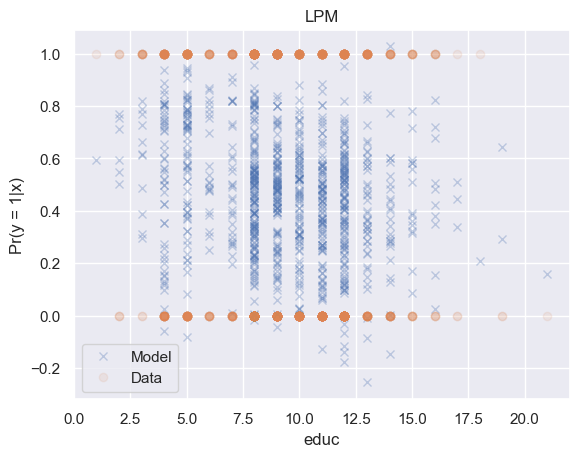

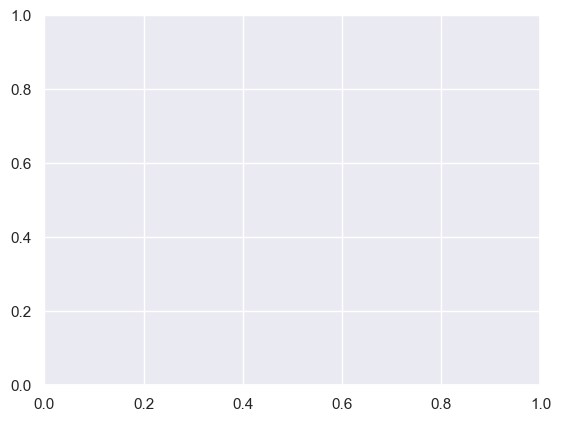

In [217]:
def plot_fit(theta, yhat, y, x, k:int, title=None): 
    '''plot_fit(): plot the predictions, f_predict(theta,x), from the model against the data
    Args. 
        theta: array of parameters, 
        yhat: fitted values 
        y: actual outcome 
        x: regressors 
        k: index for the regressor, x[:,k], to put on the x axis 
    '''
    
    fig, ax = plt.subplots(); 
    ax.plot(x[:,k], yhat, 'x', alpha=0.3, label='Model'); 
    ax.plot(x[:,k], y,    'o', alpha=0.1, label='Data')
    
    # nicify 
    ax.set_xlabel(x_lab[k]); 
    ax.set_ylabel('Pr(y = 1|x)')
    ax.set_title(title)
    ax.legend()

k = 3 # which variable to put on the x-axis 

yhatO = lm.predict(ols_results['b_hat'], x)
plot_fit(ols_results['b_hat'], yhatO, y, x, k, 'LPM')

yhatP = probit.predict(probit_results['theta'], x)
plot_fit(probit_results['theta'], yhatP, y, x, k, 'Probit')

yhatL = logit.predict(logit_results['theta'], x)
plot_fit(logit_results['theta'], yhatL, y, x, k, 'Logit')